## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality.

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-19 12:15:08--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.03s   

2023-05-19 12:15:08 (422 MB/s) - ‘data.txt’ saved [12905334/12905334]



Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set.
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [ ]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


ImportError: ignored

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9267
Unique tokens in target (en) vocabulary: 6699


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 '29',
 'соль',
 'комо',
 '―',
 'электрическая',
 'ming',
 'утренний',
 'детском',
 'таунус']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'king', 'buffets', 'catch', 'media', 'schedule', 'maraunenhof']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['laundry', 'service', 'is', 'provided', '.'], 'src': ['помимо', 'этого', ',', 'гостям', 'предоставляются', 'услуги', 'прачечной', '.']}


Let's check the length distributions:

Length distribution in Train data


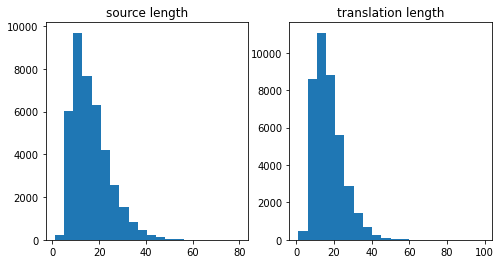

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


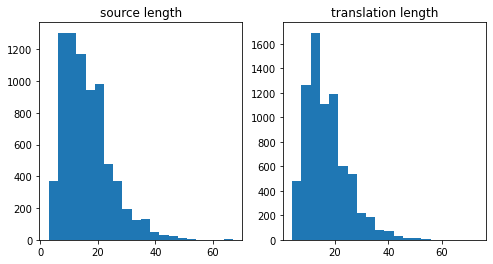

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=1)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 55x128 (GPU 1)]
	[.src]:[torch.cuda.LongTensor of size 59x128 (GPU 1)]
torch.Size([59, 128]) torch.Size([55, 128])


In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9267, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6699, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6699, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,880,299 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

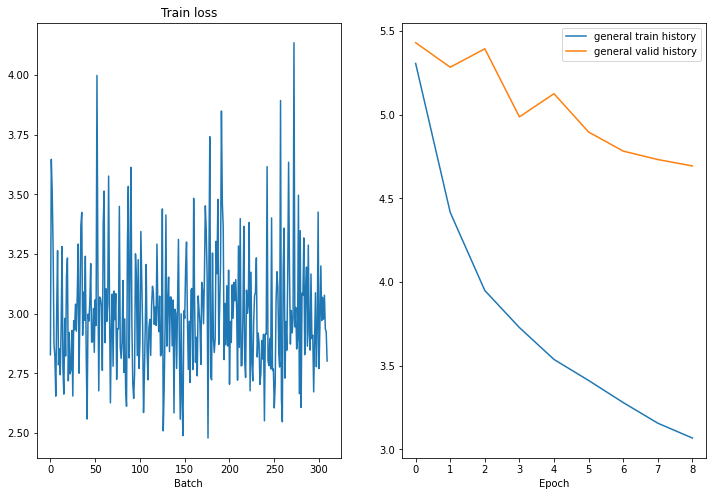

Epoch: 10 | Time: 1m 10s
	Train Loss: 2.998 | Train PPL:  20.040
	 Val. Loss: 4.710 |  Val. PPL: 111.007


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
del utils

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: the property offers a 24 - hour front desk . .

Original: this property also features free wifi .
Generated: free wifi access . . . .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 18.87it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.139920232081806

# Start Homework

## Cначала построим обычную Sequence to Sequence модель

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import torchtext

import random
import math
import time
import csv

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from collections import Counter

from torchtext.vocab import vocab as Vocab

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Data preprocessing

In [ ]:
with open("./data.txt") as f:
    data = list(csv.reader(f, delimiter="\t", quotechar='"'))

print(f"Number of training examples: {len(data)}")
print(data[0])

Number of training examples: 50000
['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.', 'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.']


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.05, random_state=1)
train, val = train_test_split(train, test_size=0.3, random_state=1)

In [ ]:
tokenizer = WordPunctTokenizer()

def tokenize(sent):
    return tokenizer.tokenize(sent.rstrip().lower())

In [ ]:
src, trg = train[0]

print(tokenize(src))
print(tokenize(trg))

['guests', 'can', 'enjoy', 'the', 'on', '-', 'site', 'restaurant', 'and', 'bar', '.']
['при', 'отеле', 'работают', 'бар', 'и', 'ресторан', '.']


In [ ]:
src_counter = Counter()
trg_counter = Counter()
for s, t in train:
    src_counter.update(tokenize(s))
    trg_counter.update(tokenize(t))

src_vocab = Vocab(src_counter, min_freq=3)
trg_vocab = Vocab(trg_counter, min_freq=3)

In [ ]:
unk_token = "<unk>"

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]
for vocab in [src_vocab, trg_vocab]:
    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

In [ ]:
print(f"Unique tokens in source (en) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target (ru) vocabulary: {len(trg_vocab)}")

Unique tokens in source (en) vocabulary: 5901
Unique tokens in target (ru) vocabulary: 8146


In [ ]:
tokenized = [sos_token] + tokenize(trg) + [eos_token]

encoded = [trg_vocab[tok] for tok in tokenized]

[(tok, idx) for tok, idx in zip(tokenized, encoded)]

[('<sos>', 8143),
 ('при', 1),
 ('отеле', 2),
 ('работают', 3),
 ('бар', 4),
 ('и', 5),
 ('ресторан', 6),
 ('.', 7),
 ('<eos>', 8144)]

In [ ]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]

In [ ]:
print(train[0][0], train[1][0])
print(encode(train[0][0], src_vocab))
print(encode(train[1][0], src_vocab))

Guests can enjoy the on-site restaurant and bar. Its location allows easy access to the city centre.
[5898, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 5899]
[5898, 12, 13, 14, 15, 16, 17, 4, 18, 19, 11, 5899]


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = encode(src, src_vocab)
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])

    return src_padded, trg_padded


batch_size = 128
train_dataloader = DataLoader(train, batch_size, shuffle=True, collate_fn=collate_batch)
src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([45, 128]), torch.Size([40, 128]))

In [ ]:
val_dataloader = DataLoader(val, batch_size, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test, batch_size, shuffle=True, collate_fn=collate_batch)

### Build and train Seq2Seq

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    i = 0
    for batch in tqdm(iterator):

        src = batch[0].to(device)
        trg = batch[1].to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()
        i += 1

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []
    i = 0

    with torch.no_grad():

        for batch in tqdm(iterator):

            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        i += 1

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train_model(model, train_iterator, valid_iterator, optimizer, criterion,
                n_epochs, clip, model_name="model_s2s.pt"):

    train_history = []
    valid_history = []
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
import my_network

In [ ]:
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5901, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(8146, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=8146, bias=True)
  )
)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,131,346 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

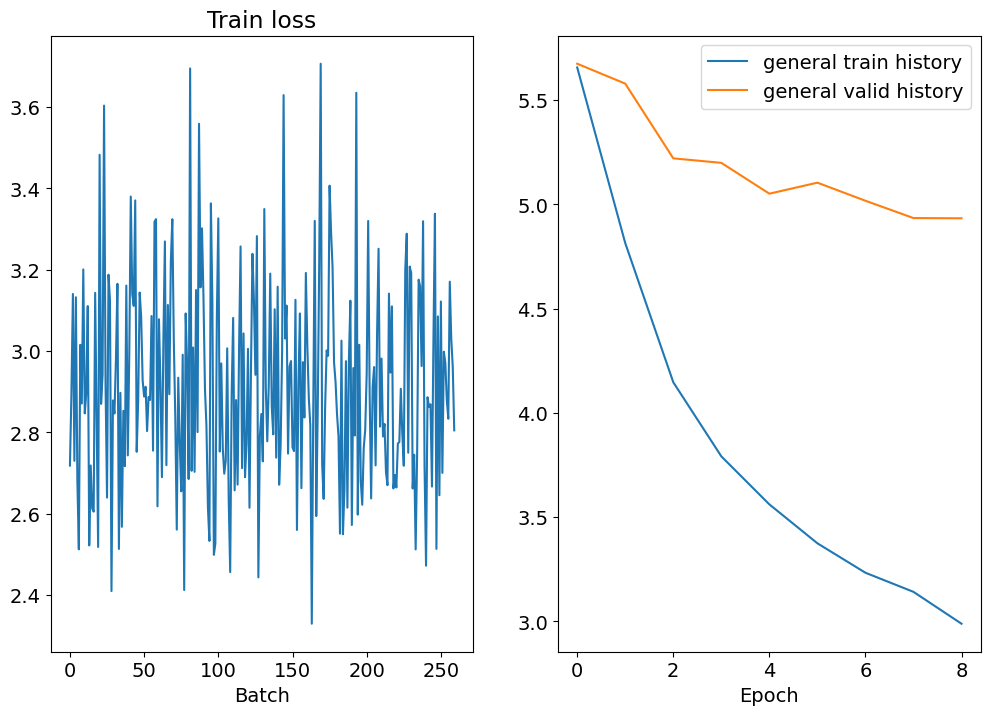

100%|██████████| 112/112 [00:23<00:00,  4.76it/s]


Epoch: 10 | Time: 2m 16s
	Train Loss: 2.916 | Train PPL:  18.474
	 Val. Loss: 4.893 |  Val. PPL: 133.379


In [ ]:
iter_train = train_dataloader
iter_val = val_dataloader
train_model(model, iter_train, iter_val,
            optimizer, criterion, n_epochs=10, clip=1, model_name="model_s2s.pt")

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_dataloader))

In [ ]:
for idx in [1,2]:
    src = batch[0][:, idx:idx+1].to(device)
    trg = batch[1][:, idx:idx+1].to(device)
    generate_translation(src, trg, model, trg_vocab)

Original: расстояние от гостевого дома « комната на » до международного аэропорта сочи ( адлер ) составляет 23 км .
Generated: расстояние от апартаментов « » до международного аэропорта тбилиси составляет 19 км .

Original: комплекс luxury rooms расположен в риме , всего в 20 минутах ходьбы от площади пьяцца - навона . к услугам гостей современно оформленные номера с бесплатным wi - fi .
Generated: апартаменты в городе , всего в 5 минутах ходьбы от пляжа . к услугам гостей номера с кондиционером и бесплатным wi - fi .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
from tqdm import tqdm

In [ ]:
def get_generated_texts(model, test_iterator):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for batch in tqdm(test_iterator):

            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, trg_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, trg_vocab) for x in output[1:].detach().cpu().numpy().T])

    return original_text, generated_text


In [ ]:
test_iterator = test_dataloader

orig_text, gen_text = get_generated_texts(model, test_iterator)
corpus_bleu([[text] for text in orig_text], gen_text) * 100

100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


15.258651434952236

In [ ]:
corpus_bleu([[text] for text in orig_text], gen_text) * 100

15.258651434952236

## Дальше попробуем Seq2Seq + Attention

### Data Prerocessing - тот же

Большинство статей в интернете используют вместо LSTM GRU (особенно когда реализовывается seq2seq + attention), так что попробуем тоже использовать GRU
P.S.: здесь примерно объясняется, почему так делают: https://github.com/bentrevett/pytorch-seq2seq/issues/47  

\+ еще заюзаем двунаправленное GRU

In [ ]:
Encoder = my_network.GRUEncoder
Attention = my_network.Attention
Decoder = my_network.AttentionGRUDecoder
Seq2Seq = my_network.AttentionSeq2Seq

In [ ]:
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

AttentionSeq2Seq(
  (encoder): GRUEncoder(
    (embedding): Embedding(5901, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionGRUDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(8146, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=8146, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,635,090 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

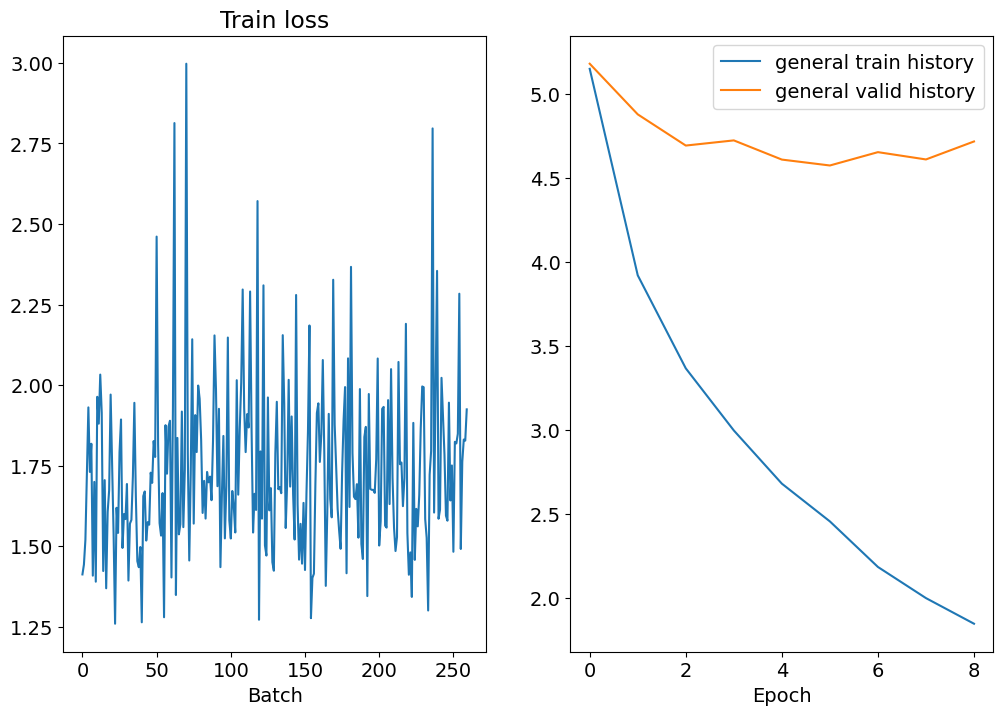

100%|██████████| 112/112 [00:44<00:00,  2.51it/s]

Epoch: 10 | Time: 4m 52s
	Train Loss: 1.738 | Train PPL:   5.685
	 Val. Loss: 4.714 |  Val. PPL: 111.541


In [ ]:
import torch.nn.functional as F

iter_train = train_dataloader
iter_val = val_dataloader
train_model(model, iter_train, iter_val,
            optimizer, criterion, n_epochs=10, clip=1, model_name="model_attn_s2s.pt")

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_dataloader))

In [ ]:
for idx in [1,2]:
    src = batch[0][:, idx:idx+1].to(device)
    trg = batch[1][:, idx:idx+1].to(device)
    generate_translation(src, trg, model, trg_vocab)

Original: по запросу организуется трансфер до болоньи и железнодорожного вокзала .
Generated: болоньи уложены лифта пивном московского автомобили птиц мигель тулум сельской основная морайра веранду тхань финская капучино храмов спортивно китами шварцвальда кофеваркой автомагистралей крумлов крыше прекрасной достоинству культурные администрация ассортиментом диско porto ледяной шейха 103 парусным матера лошадей католического множество lo орхус living завтракать океана клуб вашингтона hin грузинского мадриде гостиную построенной афон ло число гостиничный модном мессины концертного кв остановившиеся филд традиционными махдии стенах accommodation белье динар aeropuerto orange мемориала

Original: в баре отеля царит расслабляющая атмосфера , которая позволяет расслабиться с любимым напитком после дня знакомства с центром лондона .
Generated: болоньи уложены лифта пивном московского автомобили птиц мигель тулум акватория черепах султанахмет гостиные 94 обмена пьетро столами лыж economy снек 

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
from tqdm import tqdm

In [ ]:
test_iterator = test_dataloader

orig_text, gen_text = get_generated_texts(model, test_iterator)

100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


In [ ]:
corpus_bleu([[text] for text in orig_text], gen_text) * 100

28.45484187569015

## И последним применим Transformer + PositionalEncoding

### Data Prerocessing - тот же

Будем использовать в модели nn.Transformer

Также нам нужна маска, чтобы не заглядывать в будущеем и чтобы модель не обращала внимание на \<pad> токены

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == src_vocab[pad_token]).transpose(0, 1)
    tgt_padding_mask = (tgt == trg_vocab[pad_token]).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Создадим модель

In [ ]:
import my_network
Seq2SeqTransformer = my_network.Seq2SeqTransformer

In [ ]:
torch.manual_seed(0)

INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
EMB_DIM = 512
NHEAD = 8
HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_DIM,
                                 NHEAD, INPUT_DIM, OUTPUT_DIM, HID_DIM).to(device)

In [ ]:
def init_weights_transformer(m):
    for p in m.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model.apply(init_weights_transformer)

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,995,858 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

Нам понадобятся немного другие функции для обучения и валидации:

In [ ]:
def train_transformer(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    i = 0
    for batch in tqdm(iterator):

        src = batch[0].to(device)
        trg = batch[1].to(device)

        optimizer.zero_grad()

        trg_input = trg[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg_input)

        output = model(src, trg_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        trg_out = trg[1:].view(-1)

        loss = criterion(output.reshape(-1, output.shape[-1]), trg_out)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()
        i += 1
    return epoch_loss / len(iterator)

In [ ]:
def evaluate_transformer(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []
    i = 0

    with torch.no_grad():

        for batch in tqdm(iterator):

            src = batch[0].to(device)
            trg = batch[1].to(device)

            trg_input = trg[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg_input)

            output = model(src, trg_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            trg_out = trg[1:].view(-1)

            loss = criterion(output.reshape(-1, output.shape[-1]), trg_out)

            epoch_loss += loss.item()
        i += 1

    return epoch_loss / len(iterator)

In [ ]:
def train_model(model, train_iterator, valid_iterator, optimizer, criterion,
                n_epochs, clip, model_name="model_s2s.pt"):

    train_history = []
    valid_history = []
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train_transformer(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate_transformer(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

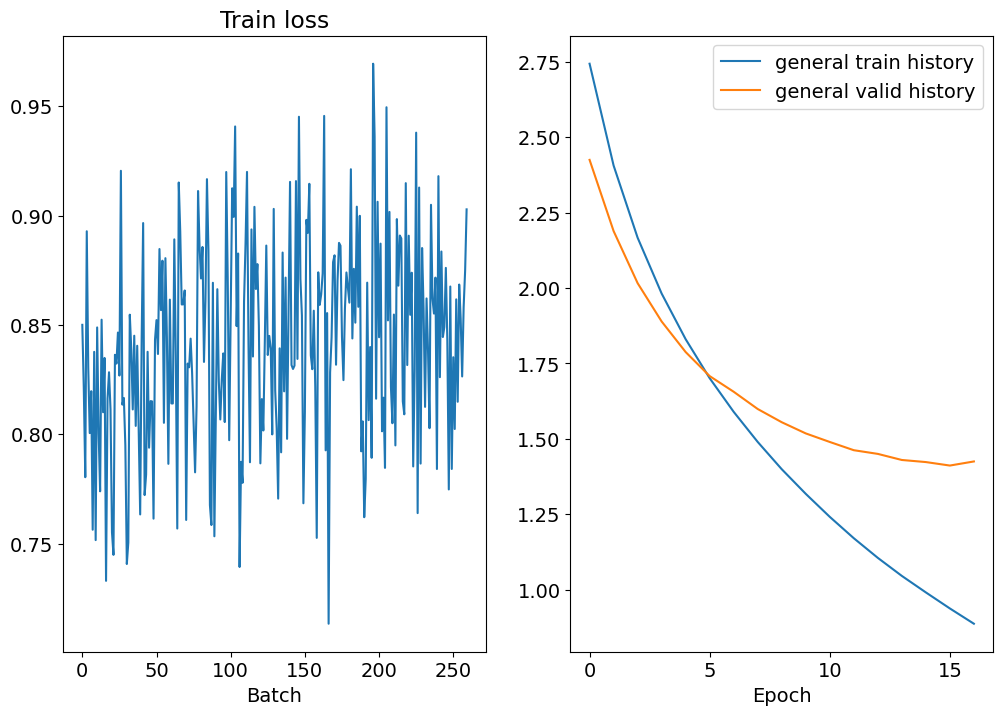

100%|██████████| 112/112 [00:09<00:00, 12.33it/s]

Epoch: 18 | Time: 1m 22s
	Train Loss: 0.841 | Train PPL:   2.319
	 Val. Loss: 1.417 |  Val. PPL:   4.124


In [ ]:
import torch.nn.functional as F

iter_train = train_dataloader
iter_val = val_dataloader
train_model(model, iter_train, iter_val,
            optimizer, criterion, n_epochs=18, clip=1, model_name="model_transformer.pt")

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
def get_generated_texts_transform(model, test_iterator):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for batch in tqdm(test_iterator):

            src = batch[0].to(device)
            trg = batch[1].to(device)

            trg_input = trg[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg_input)

            output = model(src, trg_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, trg_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, trg_vocab) for x in output[1:].detach().cpu().numpy().T])

    return original_text, generated_text


def generate_translation_transform(src, trg, model, trg_vocab):
    model.eval()

    trg_input = trg[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg_input)

    output = model(src, trg_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), trg_vocab)
    generated = get_text(list(output[1:, 0]), trg_vocab)

    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()


In [ ]:
for idx in [1,2]:
    src = batch[0][:, idx:idx+1].to(device)
    trg = batch[1][:, idx:idx+1].to(device)
    generate_translation_transform(src, trg, model, trg_vocab)

Original: в некоторых номерах есть гостиная зона .
Generated: некоторых номерах обустроена гостиная зона .

Original: в зонах общественного пользования отеля предоставляется бесплатный беспроводной доступ в интернет .
Generated: зонах общественного пользования отеля предоставляется бесплатный wi доступ в интернет .



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
batch = next(iter(test_dataloader))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
from tqdm import tqdm

In [ ]:
test_iterator = test_dataloader

orig_text, gen_text = get_generated_texts_transform(model, test_iterator)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


In [ ]:
corpus_bleu([[text] for text in orig_text], gen_text) * 100

42.69715104358136